In [2]:
import h5_getter
import numpy as np
import os
import pypianoroll
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import librosa
import music21
import random
import json
import itertools
import datetime
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
notes_train = json.load(open('train_notes.json'))
notes_test = json.load(open('test_notes.json'))

In [3]:
# Prepare input and output sequences
def prepare_sequences(notes, note_to_int = None, sequence_length = 32):
    network_input = []
    network_output = []

    if not note_to_int:
        # Set of note/chords (collapse into list)
        pitch_names = sorted(set(itertools.chain(*notes)))
        # create a dictionary to map pitches to integers
        note_to_int = dict((note, number) for number, note in enumerate(pitch_names))

    # Loop through all songs
    for song in notes:
        # Check for the end
        i = 0
        while i + sequence_length < len(song):
            # seq_len notes for the input seq
            sequence_in = song[i: i + sequence_length]
            # Next note to predict
            sequence_out = song[i+sequence_length]
            # Return the int representation of the note - *(If note not found)
            network_input.append([note_to_int.get(char, 0) for char in sequence_in])
            network_output.append(note_to_int.get(sequence_out, 0))
            i += 32

    n_patterns = len(network_input)

    # Reshape for LSTM input
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_output = np.reshape(network_output, (n_patterns, 1))
    # Normalize input (?? - CHECK LATER - this assumes the alphabetical order of the notes carries semantic meaning?)
    #network_input = network_input / len(pitch_names)
    #network_output = np_utils.to_categorical(network_output)

    return network_input, network_output, note_to_int

train_input, train_output, note_to_int = prepare_sequences(notes_train, sequence_length = 64)
#test_input, test_output, _ = prepare_sequences(notes_test, note_to_int = note_to_int, sequence_length = 64)

In [4]:
int_to_note = dict((number, note) for number, note in enumerate(note_to_int))

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, input, output, note_to_int = None):
        self.input = input
        # One-hot encode the output=
        self.output = torch.nn.functional.one_hot(output, num_classes = len(note_to_int)).float()
        self.output = output

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]
    
train_dataset = Dataset(torch.tensor(train_input, dtype=torch.long), torch.tensor(train_output.squeeze(), dtype=torch.long), note_to_int)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [69]:
class My_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output
    

class My_RNN(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_RNN, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        output = self.fc(rnn_out[:, -1, :])
        return output

In [70]:
output_size = len(note_to_int)
lstm_model = My_LSTM(output_size, output_size, embedding_dim=571, hidden_dim=100).to(device)
rnn_model = My_RNN(output_size, output_size, embedding_dim=571, hidden_dim=100).to(device)

Epoch [10/250], Step [31/31], Loss: 2.3505969047546387
Epoch [20/250], Step [31/31], Loss: 1.3249622583389282
Epoch [30/250], Step [31/31], Loss: 0.6287069320678711
Epoch [40/250], Step [31/31], Loss: 0.3980090916156769
Epoch [50/250], Step [31/31], Loss: 0.25056591629981995
Epoch [60/250], Step [31/31], Loss: 0.1791575849056244
Epoch [70/250], Step [31/31], Loss: 0.09324252605438232
Epoch [80/250], Step [31/31], Loss: 0.0779263898730278
Epoch [90/250], Step [31/31], Loss: 0.057043544948101044
Epoch [100/250], Step [31/31], Loss: 0.028764022514224052
Epoch [110/250], Step [31/31], Loss: 0.10961675643920898
Epoch [120/250], Step [31/31], Loss: 0.04672503471374512
Epoch [130/250], Step [31/31], Loss: 0.05812468007206917
Epoch [140/250], Step [31/31], Loss: 0.01765836775302887
Epoch [150/250], Step [31/31], Loss: 0.013703368604183197
Epoch [160/250], Step [31/31], Loss: 0.010444346815347672
Epoch [170/250], Step [31/31], Loss: 0.010859434492886066
Epoch [180/250], Step [31/31], Loss: 0.25

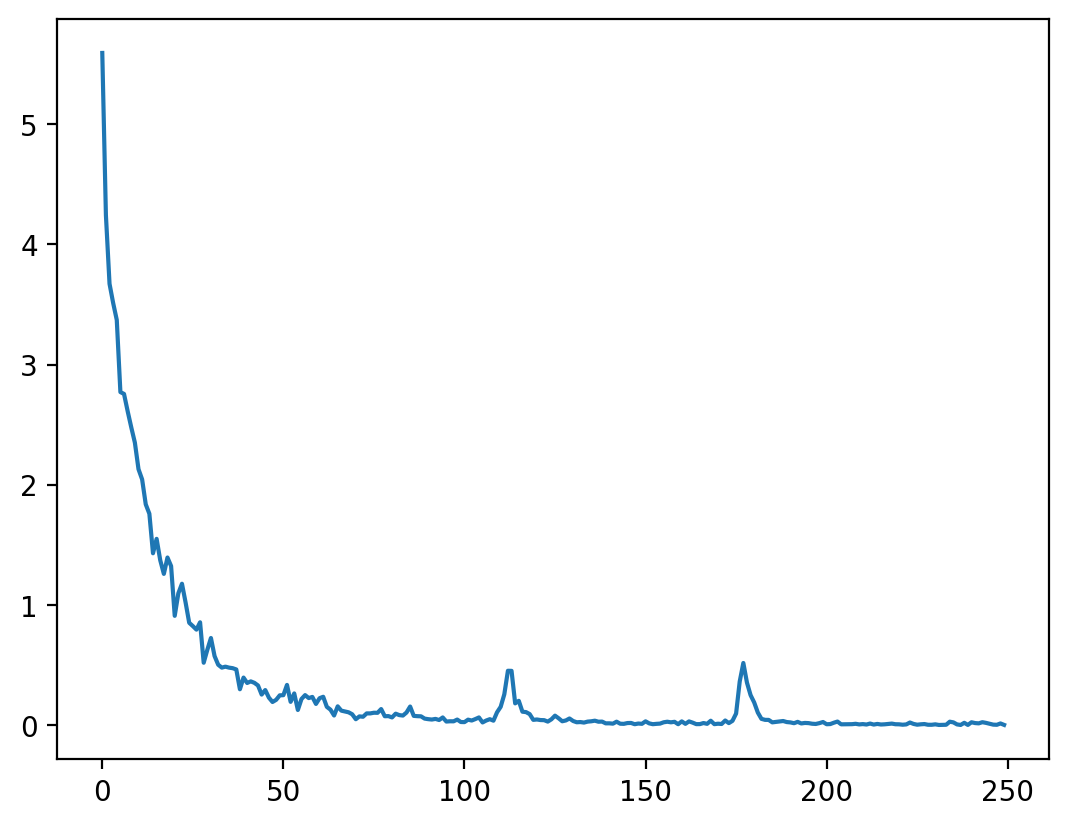

In [71]:
model = lstm_model
save_path = 'lstm_model'

model.train()
num_epochs = 250
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []

lowest_loss = 1000

for epoch in range(num_epochs):
    for i, (input, output) in enumerate(train_loader):
        input = input.to(device)
        output = output.to(device)
        input = input.squeeze()
        pred = model(input)
        loss = criterion(pred, output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            torch.save(model.state_dict(), f'{save_path}.pth')
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    losses.append(loss.item())

plt.plot(losses)
plt.show()

In [72]:
losses = np.array(losses)
np.save('LSTM_losses.npy', losses)


Epoch [10/250], Step [31/31], Loss: 0.1302635222673416
Epoch [20/250], Step [31/31], Loss: 0.05012880265712738
Epoch [30/250], Step [31/31], Loss: 0.023621823638677597
Epoch [40/250], Step [31/31], Loss: 0.03595276549458504
Epoch [50/250], Step [31/31], Loss: 0.042193420231342316
Epoch [60/250], Step [31/31], Loss: 0.02474662847816944
Epoch [70/250], Step [31/31], Loss: 0.05014704912900925
Epoch [80/250], Step [31/31], Loss: 0.017023833468556404
Epoch [90/250], Step [31/31], Loss: 0.0088436184450984
Epoch [100/250], Step [31/31], Loss: 0.005270109977573156
Epoch [110/250], Step [31/31], Loss: 0.011785902082920074
Epoch [120/250], Step [31/31], Loss: 0.0038040075451135635
Epoch [130/250], Step [31/31], Loss: 0.03623887896537781
Epoch [140/250], Step [31/31], Loss: 0.017541931942105293
Epoch [150/250], Step [31/31], Loss: 0.0053767855279147625
Epoch [160/250], Step [31/31], Loss: 0.003902903525158763
Epoch [170/250], Step [31/31], Loss: 0.0036103089805692434
Epoch [180/250], Step [31/31]

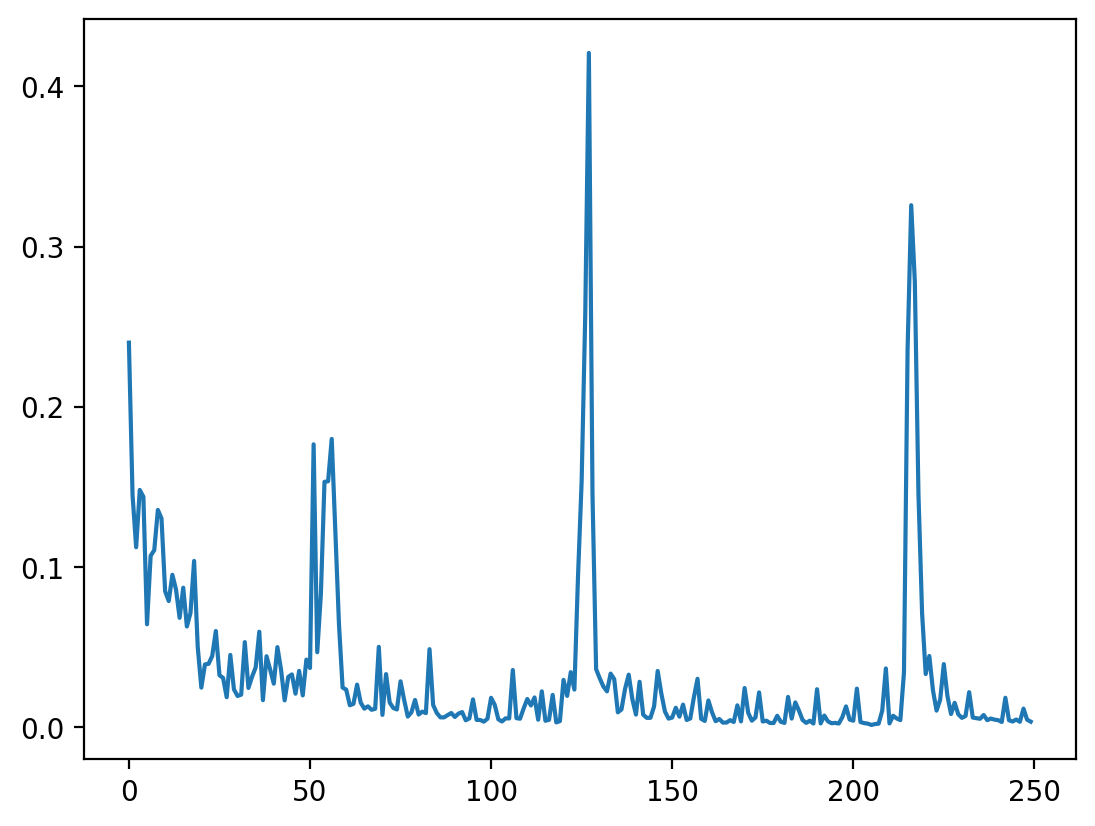

In [75]:
model = rnn_model
save_path = 'rnn_model'

model.train()
num_epochs = 250
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []

lowest_loss = 1000

for epoch in range(num_epochs):
    for i, (input, output) in enumerate(train_loader):
        input = input.to(device)
        output = output.to(device)
        input = input.squeeze()
        pred = model(input)
        loss = criterion(pred, output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            torch.save(model.state_dict(), f'{save_path}.pth')
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    losses.append(loss.item())

plt.plot(losses)
plt.show()

In [76]:
losses = np.array(losses)
np.save('rnn_losses.npy', losses)

In [3]:
rnn_losses = np.load('rnn_losses.npy')
lstm_losses = np.load('LSTM_losses.npy')
transformer_losses = np.load('transformer_losses.npy')

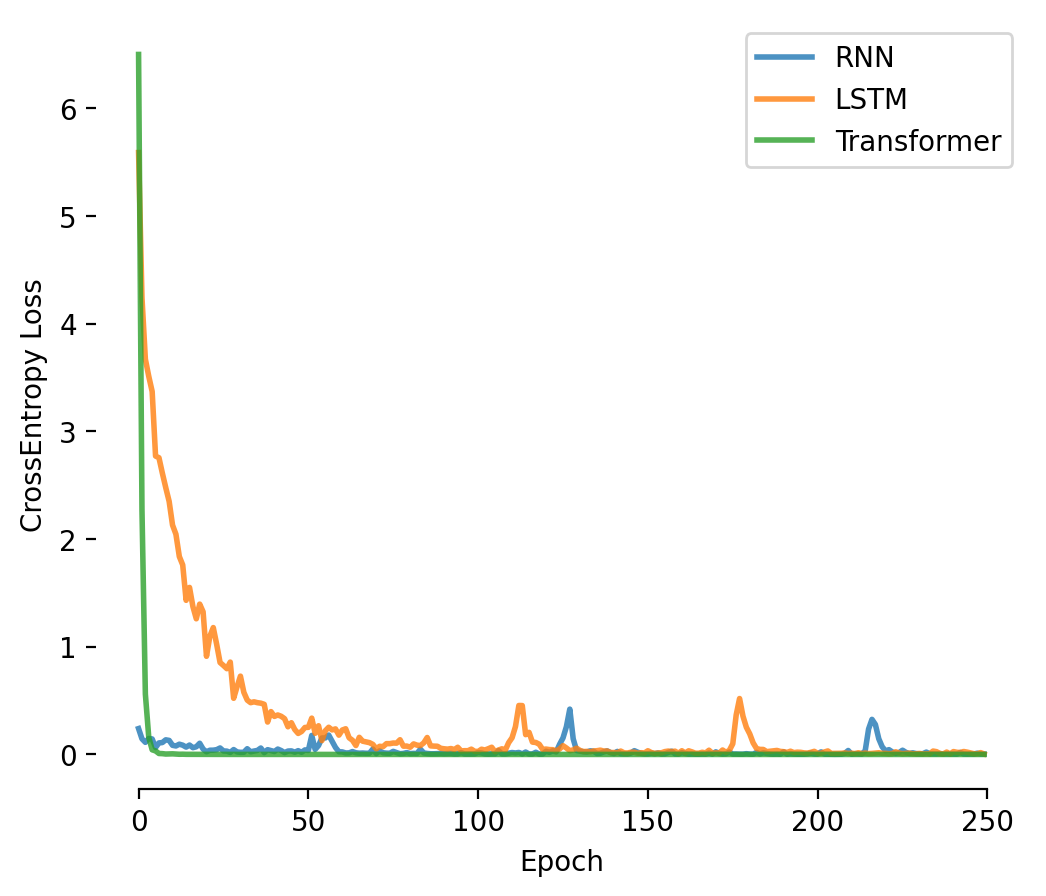

In [6]:
fig, ax = plt.subplots(
    figsize=(6, 5)
)

ax.plot(rnn_losses, label='RNN', color='tab:blue', linewidth=2, alpha=0.8)
ax.plot(lstm_losses, label='LSTM', color='tab:orange', linewidth=2, alpha=0.8)
ax.plot(transformer_losses, label='Transformer', color='tab:green', linewidth=2, alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('CrossEntropy Loss')  
ax.legend()

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_bounds(0, 250)

plt.savefig('loss_comparison.pdf', bbox_inches='tight', format='pdf')

In [51]:
# Loading of models
model = My_LSTM(output_size, output_size, embedding_dim=64, hidden_dim=200).to(device)
model.load_state_dict(torch.load('model-lstm.pth'))

<All keys matched successfully>

In [95]:
def generate_notes(model, note_to_int, int_to_note, length = 100):
    model.eval()
    notes = []
    note = random.choice(list(int_to_note.keys()))
    notes.append(note)
    for i in range(length):
        input = torch.tensor(notes[-64:], dtype=torch.long).unsqueeze(0).to(device)
        pred = model(input)
        pred = F.softmax(pred, dim=1).cpu().detach().numpy().flatten()
        # sample from the distribution
        note = np.random.choice(len(int_to_note), 1, p=pred)[0]
        notes.append(note)
    return [int_to_note[note] for note in notes]

In [96]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = music21.note.Note(int(current_note))
                new_note.storedInstrument = music21.instrument.Piano()
                notes.append(new_note)
            new_chord = music21.chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = music21.note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = music21.instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = music21.stream.Stream(output_notes)

    return midi_stream

In [129]:
generated_notes = generate_notes(lstm_model, note_to_int, int_to_note, length = 100)

In [130]:
midi_stream = create_midi(generated_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'

In [94]:
midi_data = pretty_midi.PrettyMIDI('good_samp1.mid')
cropped_output = midi_data.instruments[0].notes[:100]
midi_data.instruments[0].notes = cropped_output
midi_data.write('test_output.mid')